# Modello baseline: TF-IDF + Logistic Regression

In questo notebook viene costruita la **baseline di classificazione** per il sistema di triage automatico dei ticket.

Obiettivi di questa sezione:
- Utilizzare il dataset già preprocessato `tickets_preprocessed_split.csv`
- Addestrare due modelli distinti:
  - Classificazione **categoria** (Amministrazione / Tecnico / Commerciale)
  - Classificazione **priorità** (bassa / media / alta)
- Utilizzare una pipeline **TF-IDF + Logistic Regression** come modello di base
- Valutare le performance con:
  - Accuracy
  - F1 macro
  - Classification report
  - Matrice di confusione
- Estrarre le parole più influenti per ciascuna classe (utile per la dashboard)


In [1]:
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_it = stopwords.words('italian')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lavezzidie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Caricamento del dataset preprocessato

Il dataset `../data/tickets_preprocessed_split.csv` contiene:
- testo originale (`title`, `body`)
- testo combinato (`text`)
- versione pulita del testo (`text_clean`)
- etichette (`category`, `priority`)
- colonna `split` che distingue **train** e **test**


In [2]:
# Carica il dataset preprocessato
df = pd.read_csv(DATA_DIR / "splits" / "tickets_preprocessed_split.csv")

# Controllo rapido delle colonne e delle prime righe
print(df.columns)
df.head()


Index(['id', 'title', 'body', 'category', 'priority', 'title_length',
       'body_length', 'text', 'text_clean', 'len_words_raw', 'len_words_clean',
       'split'],
      dtype='object')


,id,title,body,category,priority,title_length,body_length,text,text_clean,len_words_raw,len_words_clean,split
0,1,NaN,Timeout puntuale durante la ricerca fatture pe...,Amministrazione,media,0,314,Timeout puntuale durante la ricerca fatture pe...,timeout puntuale durante la ricerca fatture pe...,46,47,train
1,2,NaN,Nota di aggiornamento anagrafica per cliente F...,Amministrazione,bassa,0,297,Nota di aggiornamento anagrafica per cliente F...,nota di aggiornamento anagrafica per cliente f...,41,44,test
2,3,NaN,Durante l'elaborazione della fattura 8641/21 p...,Amministrazione,alta,0,376,Durante l'elaborazione della fattura 8641/21 p...,durante l elaborazione della fattura 8641 21 p...,50,58,train
3,4,NaN,L'utente admin_01 segnala lentezza esasperante...,Amministrazione,media,0,261,L'utente admin_01 segnala lentezza esasperante...,l utente admin_01 segnala lentezza esasperante...,35,39,train
4,5,NaN,Procedura di bcakup storico: exoprt fatture an...,Amministrazione,bassa,0,312,Procedura di bcakup storico: exoprt fatture an...,procedura di bcakup storico exoprt fatture ann...,47,47,train


In [3]:
# Verifica della colonna 'split'
df["split"].value_counts()

split
train    384
test      96
Name: count, dtype: int64

## Costruzione dei set di training e test

Utilizzo della colonna `split` per separare:
- `X_train`, `y_train_cat`, `y_train_prio`
- `X_test`, `y_test_cat`, `y_test_prio`

Come input testuale viene utilizzata la colonna `text_clean` contenente il testo già pulito.


In [4]:
# Feature testuale 
X_train = df[df["split"] == "train"]["text_clean"]
X_test  = df[df["split"] == "test"]["text_clean"]

# Target per categoria
y_train_cat = df[df["split"] == "train"]["category"]
y_test_cat  = df[df["split"] == "test"]["category"]

# Target per priorità
y_train_prio = df[df["split"] == "train"]["priority"]
y_test_prio  = df[df["split"] == "test"]["priority"]

print("Dimensioni training:", X_train.shape[0])
print("Dimensioni test:", X_test.shape[0])


Dimensioni training: 384
Dimensioni test: 96


In [5]:
print("Distribuzione categoria - train:")
print(y_train_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione categoria - test:")
print(y_test_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - train:")
print(y_train_prio.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - test:")
print(y_test_prio.value_counts(normalize=True).round(3))


Distribuzione categoria - train:
category
Tecnico            0.451
Amministrazione    0.299
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione categoria - test:
category
Tecnico            0.448
Amministrazione    0.302
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione priorità - train:
priority
media    0.461
bassa    0.281
alta     0.258
Name: proportion, dtype: float64

Distribuzione priorità - test:
priority
media    0.438
bassa    0.323
alta     0.240
Name: proportion, dtype: float64


## Modello 1 – Classificazione **categoria** con TF-IDF + Logistic Regression

In questo modello:
- Rappresentazione del testo: **TF-IDF** con uni- e bi-grammi
- Classificatore: **Logistic Regression** multiclasse
- Gestione di possibili sbilanciamenti: `class_weight="balanced"`

Questa combinazione costituisce la **baseline** per la classificazione di categoria.


In [6]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)
        
    # minuscole (e togli lowercase=False dal TFIDF)
    text = text.lower()
    
    # rimuovi solo simboli non utili
    text = re.sub(r"[^\w\sàèéìòù]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [7]:
pipe_cat = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),     
        max_features=200,
        min_df=2,             
        max_df=0.8,
        strip_accents="unicode"        
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipe_cat


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001BC05A220C0>
,tokenizer,None


In [8]:
pipe_cat.fit(X_train, y_train_cat)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001BC05A220C0>
,tokenizer,None


### Valutazione del modello per categoria

Metriche considerate:
- **Accuracy**: quota di predizioni corrette sul test set
- **F1 macro**: media dell'F1 calcolata separatamente su ciascuna classe (tutte le classi pesano uguale)
- **Classification report**: precision, recall, F1 per classe
- **Matrice di confusione**: errori per coppia (vera classe, classe predetta)


In [9]:
# Predizioni sul test set
y_pred_cat = pipe_cat.predict(X_test)

# Metriche
acc_cat = accuracy_score(y_test_cat, y_pred_cat)
f1_cat = f1_score(y_test_cat, y_pred_cat, average="macro")

print(f"Accuracy (categoria): {acc_cat:.3f}")
print(f"F1 macro (categoria): {f1_cat:.3f}")

print("\nClassification report (categoria):")
print(classification_report(y_test_cat, y_pred_cat))


Accuracy (categoria): 0.896
F1 macro (categoria): 0.897

Classification report (categoria):
                 precision    recall  f1-score   support

Amministrazione       0.83      0.86      0.85        29
    Commerciale       0.92      0.96      0.94        24
        Tecnico       0.93      0.88      0.90        43

       accuracy                           0.90        96
      macro avg       0.89      0.90      0.90        96
   weighted avg       0.90      0.90      0.90        96



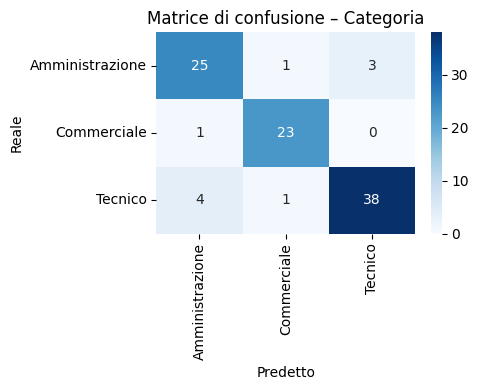

,Amministrazione,Commerciale,Tecnico
Amministrazione,25,1,3
Commerciale,1,23,0
Tecnico,4,1,38


In [10]:
labels_cat = sorted(y_train_cat.unique())

cm_cat = confusion_matrix(y_test_cat, y_pred_cat, labels=labels_cat)
cm_cat_df = pd.DataFrame(cm_cat, index=labels_cat, columns=labels_cat)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_cat_df, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di confusione – Categoria")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_cat_df


## Modello 2 – Classificazione **priorità** con TF-IDF + Logistic Regression

Replica dello stesso approccio utilizzato per la categoria, ma con target `priority`.

L’obiettivo è:
- capire quanto è più difficile stimare la priorità rispetto alla categoria
- confrontare le metriche delle due task (categoria vs priorità).


In [11]:
custom_weights = {"alta": 1, "media": 1, "bassa": 1.5} 

pipe_prio = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        min_df=2,             
        max_df=0.8,
        strip_accents="unicode"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipe_prio


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001BC05A220C0>
,tokenizer,None


In [12]:
pipe_prio.fit(X_train, y_train_prio)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001BC05A220C0>
,tokenizer,None


In [13]:
y_pred_prio = pipe_prio.predict(X_test)

acc_prio = accuracy_score(y_test_prio, y_pred_prio)
f1_prio = f1_score(y_test_prio, y_pred_prio, average="macro")

print(f"Accuracy (priorità): {acc_prio:.3f}")
print(f"F1 macro (priorità): {f1_prio:.3f}")

print("\nClassification report (priorità):")
print(classification_report(y_test_prio, y_pred_prio))


Accuracy (priorità): 0.844
F1 macro (priorità): 0.844

Classification report (priorità):
              precision    recall  f1-score   support

        alta       0.78      0.91      0.84        23
       bassa       0.89      0.81      0.85        31
       media       0.85      0.83      0.84        42

    accuracy                           0.84        96
   macro avg       0.84      0.85      0.84        96
weighted avg       0.85      0.84      0.84        96



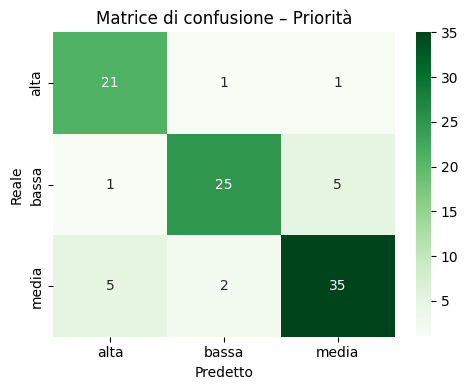

,alta,bassa,media
alta,21,1,1
bassa,1,25,5
media,5,2,35


In [14]:
labels_prio = sorted(y_train_prio.unique())

cm_prio = confusion_matrix(y_test_prio, y_pred_prio, labels=labels_prio)
cm_prio_df = pd.DataFrame(cm_prio, index=labels_prio, columns=labels_prio)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_prio_df, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice di confusione – Priorità")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_prio_df


## Feature più influenti per classe

Per aumentare l’interpretabilità del modello, si analizzano i coefficienti della **Logistic Regression**, che consentono di stimare il contributo di ciascun termine alla decisione del classificatore.
In particolare, vengono estratte le parole con coefficiente positivo più elevato per ogni classe di output (categoria e priorità), interpretandole come i termini maggiormente associati a ciascuna etichetta.
Queste informazioni verranno successivamente utilizzate nella dashboard per mostrare, a fini esplicativi, le top 5 parole più influenti nella predizione.


In [15]:
# Estrazione componenti dalla pipeline
vec_cat = pipe_cat.named_steps["tfidf"]
clf_cat = pipe_cat.named_steps["clf"]

feature_names_cat = np.array(vec_cat.get_feature_names_out())
classes_cat = clf_cat.classes_

top_k = 5

for idx, cls in enumerate(classes_cat):
    coefs = clf_cat.coef_[idx]
    top_idx = np.argsort(coefs)[-top_k:]
    print(f"\nClasse categoria: {cls}")
    for i in reversed(top_idx):
        print(f"  {feature_names_cat[i]}  (peso: {coefs[i]:.3f})")



Classe categoria: Amministrazione
  fatture  (peso: 1.936)
  risulta  (peso: 1.396)
  upload  (peso: 1.351)
  serve  (peso: 1.241)
  documenti  (peso: 1.075)

Classe categoria: Commerciale
  cliente  (peso: 1.995)
  crm  (peso: 1.804)
  offerta  (peso: 1.694)
  prodotto  (peso: 1.143)
  contatti  (peso: 1.135)

Classe categoria: Tecnico
  ordini  (peso: 1.433)
  indice  (peso: 1.027)
  test  (peso: 0.979)
  query  (peso: 0.917)
  reportistica  (peso: 0.894)


In [16]:
vec_prio = pipe_prio.named_steps["tfidf"]
clf_prio = pipe_prio.named_steps["clf"]

feature_names_prio = np.array(vec_prio.get_feature_names_out())
classes_prio = clf_prio.classes_

top_k = 5

for idx, cls in enumerate(classes_prio):
    coefs = clf_prio.coef_[idx]
    top_idx = np.argsort(coefs)[-top_k:]
    print(f"\nClasse priorità: {cls}")
    for i in reversed(top_idx):
        print(f"  {feature_names_prio[i]}  (peso: {coefs[i]:.3f})")



Classe priorità: alta
  ordine  (peso: 2.420)
  urgente  (peso: 2.029)
  critico  (peso: 1.974)
  ordine urgente  (peso: 1.738)
  bloccato  (peso: 1.669)

Classe priorità: bassa
  attività  (peso: 1.446)
  nessuna  (peso: 1.124)
  pianificare  (peso: 1.123)
  suggerimento  (peso: 1.109)
  archivio  (peso: 1.085)

Classe priorità: media
  problema  (peso: 1.170)
  record  (peso: 0.842)
  timeout  (peso: 0.835)
  lentezza  (peso: 0.794)
  validazione  (peso: 0.767)


## Salvataggio delle metriche TF-IDF + Logistic Regression

Le metriche ottenute vengono salvate per poter essere utilizzate nel confronto tra modelli

In [17]:
results_lr = {
    "categoria_accuracy": acc_cat,
    "categoria_f1": f1_cat,
    "priorita_accuracy": acc_prio,
    "priorita_f1": f1_prio
}

import json
with open(DATA_DIR / "results_baseline" / "results_logistic.json", "w") as f:
    json.dump(results_lr, f)


In [18]:
import json

results_lr = {
    "categoria_accuracy": float(acc_cat),
    "categoria_f1_macro": float(f1_cat),
    "priorita_accuracy": float(acc_prio),
    "priorita_f1_macro": float(f1_prio)
}

with open(DATA_DIR / "results_baseline" / "logistic_metrics.json", "w") as f:
    json.dump(results_lr, f, indent=4)


In [19]:
cm_cat_df.to_csv(DATA_DIR / "results_baseline" / "confusion_cat_logreg.csv", index=True)
cm_prio_df.to_csv(DATA_DIR / "results_baseline" / "confusion_prio_logreg.csv", index=True)



In [20]:
with open(DATA_DIR / "results_baseline" / "topwords_cat_logreg.txt", "w") as f:
    for idx, cls in enumerate(classes_cat):
        f.write(f"\nClasse: {cls}\n")
        coefs = clf_cat.coef_[idx]
        top_idx = np.argsort(coefs)[-10:]
        for i in reversed(top_idx):
            f.write(f"  {feature_names_cat[i]} ({coefs[i]:.3f})\n")
